In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from data import RoadSatelliteModule
from system import SemanticSegmentationSystem

from models import *

import numpy as np
import matplotlib.pyplot as plt
import random

import torchvision
import torchvision.transforms.functional as F

import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping

import torch
from torchinfo import summary

# 1. Preparation

In [3]:
batch_size = 8
num_workers = 8

In [4]:
pl.seed_everything(33, workers=True)

Global seed set to 33


33

## 1.1 DataModule

In [5]:
road_data = RoadSatelliteModule()

In [6]:
%%time
X, y = next(iter(road_data.train_dataloader()))

CPU times: user 2.35 s, sys: 1.53 s, total: 3.87 s
Wall time: 8.91 s


In [7]:
X.shape

torch.Size([8, 3, 160, 160])

## 1.2 Inspect Data

In [8]:
def show_image(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

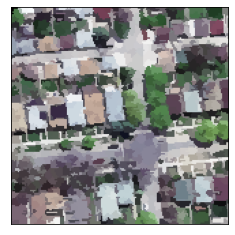

In [9]:
show_image(X[0])

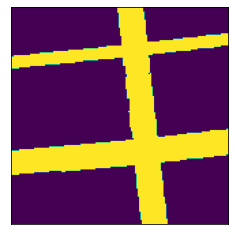

In [10]:
show_image(y[0])

# 2. Define Model / System

In [11]:
model = UNet_3Plus_Spatial()

In [12]:
summary(model, input_size=X.shape)

/cluster/home/mboss/.virtualenvs/mp-env/lib64/python3.7/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Layer (type:depth-idx)                                  Output Shape              Param #
UNet_3Plus_Spatial                                      --                        --
├─unetConv2: 1-1                                        [8, 64, 160, 160]         --
│    └─Sequential: 2-1                                  [8, 64, 160, 160]         --
│    │    └─Conv2d: 3-1                                 [8, 64, 160, 160]         1,792
│    │    └─BatchNorm2d: 3-2                            [8, 64, 160, 160]         128
│    │    └─ReLU: 3-3                                   [8, 64, 160, 160]         --
│    └─Sequential: 2-2                                  [8, 64, 160, 160]         --
│    │    └─Conv2d: 3-4                                 [8, 64, 160, 160]         36,928
│    │    └─BatchNorm2d: 3-5                            [8, 64, 160, 160]         128
│    │    └─ReLU: 3-6                                   [8, 64, 160, 160]         --
├─MaxPool2d: 1-2                                   

In [13]:
system = SemanticSegmentationSystem(model, road_data)

# 4. Training

In [14]:
early_stop_callback = EarlyStopping(
   monitor='validation_accuracy',
   patience=20,
   verbose=2,
   mode='max'
)

In [15]:
trainer = pl.Trainer(
    #fast_dev_run=True,
    gpus=-1,
    auto_select_gpus=True,
    stochastic_weight_avg=True,
    benchmark=True,
    callbacks=[early_stop_callback]
)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores


In [ ]:
%%time
trainer.fit(system)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type               | Params
-------------------------------------------------
0 | model     | UNet_3Plus_Spatial | 27.4 M
1 | dice_loss | DiceLoss           | 0     
-------------------------------------------------
27.4 M    Trainable params
0         Non-trainable params
27.4 M    Total params
109.582   Total estimated model params size (MB)


Epoch     0: adjusting learning rate of group 0 to 1.0000e-03.


Validation sanity check: 0it [00:00, ?it/s]

Global seed set to 33


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric validation_accuracy improved. New best score: 0.775


Epoch     1: adjusting learning rate of group 0 to 9.7555e-04.


Validating: 0it [00:00, ?it/s]

Epoch     2: adjusting learning rate of group 0 to 9.0460e-04.


Validating: 0it [00:00, ?it/s]

Epoch     3: adjusting learning rate of group 0 to 7.9410e-04.


Validating: 0it [00:00, ?it/s]

Epoch     4: adjusting learning rate of group 0 to 6.5485e-04.


Validating: 0it [00:00, ?it/s]

Metric validation_accuracy improved by 0.024 >= min_delta = 0.0. New best score: 0.799


Epoch     5: adjusting learning rate of group 0 to 5.0050e-04.


Validating: 0it [00:00, ?it/s]

Epoch     6: adjusting learning rate of group 0 to 3.4615e-04.


Validating: 0it [00:00, ?it/s]

Metric validation_accuracy improved by 0.037 >= min_delta = 0.0. New best score: 0.836


Epoch     7: adjusting learning rate of group 0 to 2.0690e-04.


Validating: 0it [00:00, ?it/s]

Epoch     8: adjusting learning rate of group 0 to 9.6396e-05.


Validating: 0it [00:00, ?it/s]

Epoch     9: adjusting learning rate of group 0 to 2.5447e-05.


Validating: 0it [00:00, ?it/s]

Epoch    10: adjusting learning rate of group 0 to 1.0000e-03.


In [ ]:
model.cuda()

In [ ]:
system.visualize_results()

In [ ]:
system.visualize_results_overlay()